In [9]:
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pysd
from pysd.translators.vensim.vensim_file import VensimFile
from pysd.translators.xmile.xmile_file import XmileFile
from pysd.builders.stan.stan_model_builder import *

import cmdstanpy # 2.30 is fastest (as of 08.12.2022) `cmdstanpy.install_cmdstan()` 
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az #!pip install git+https://github.com/arviz-devs/arviz
az.style.use("arviz-darkgrid")

# set your working directiory
os.chdir("/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts")

## U1. Draft
From mental model to SD model.
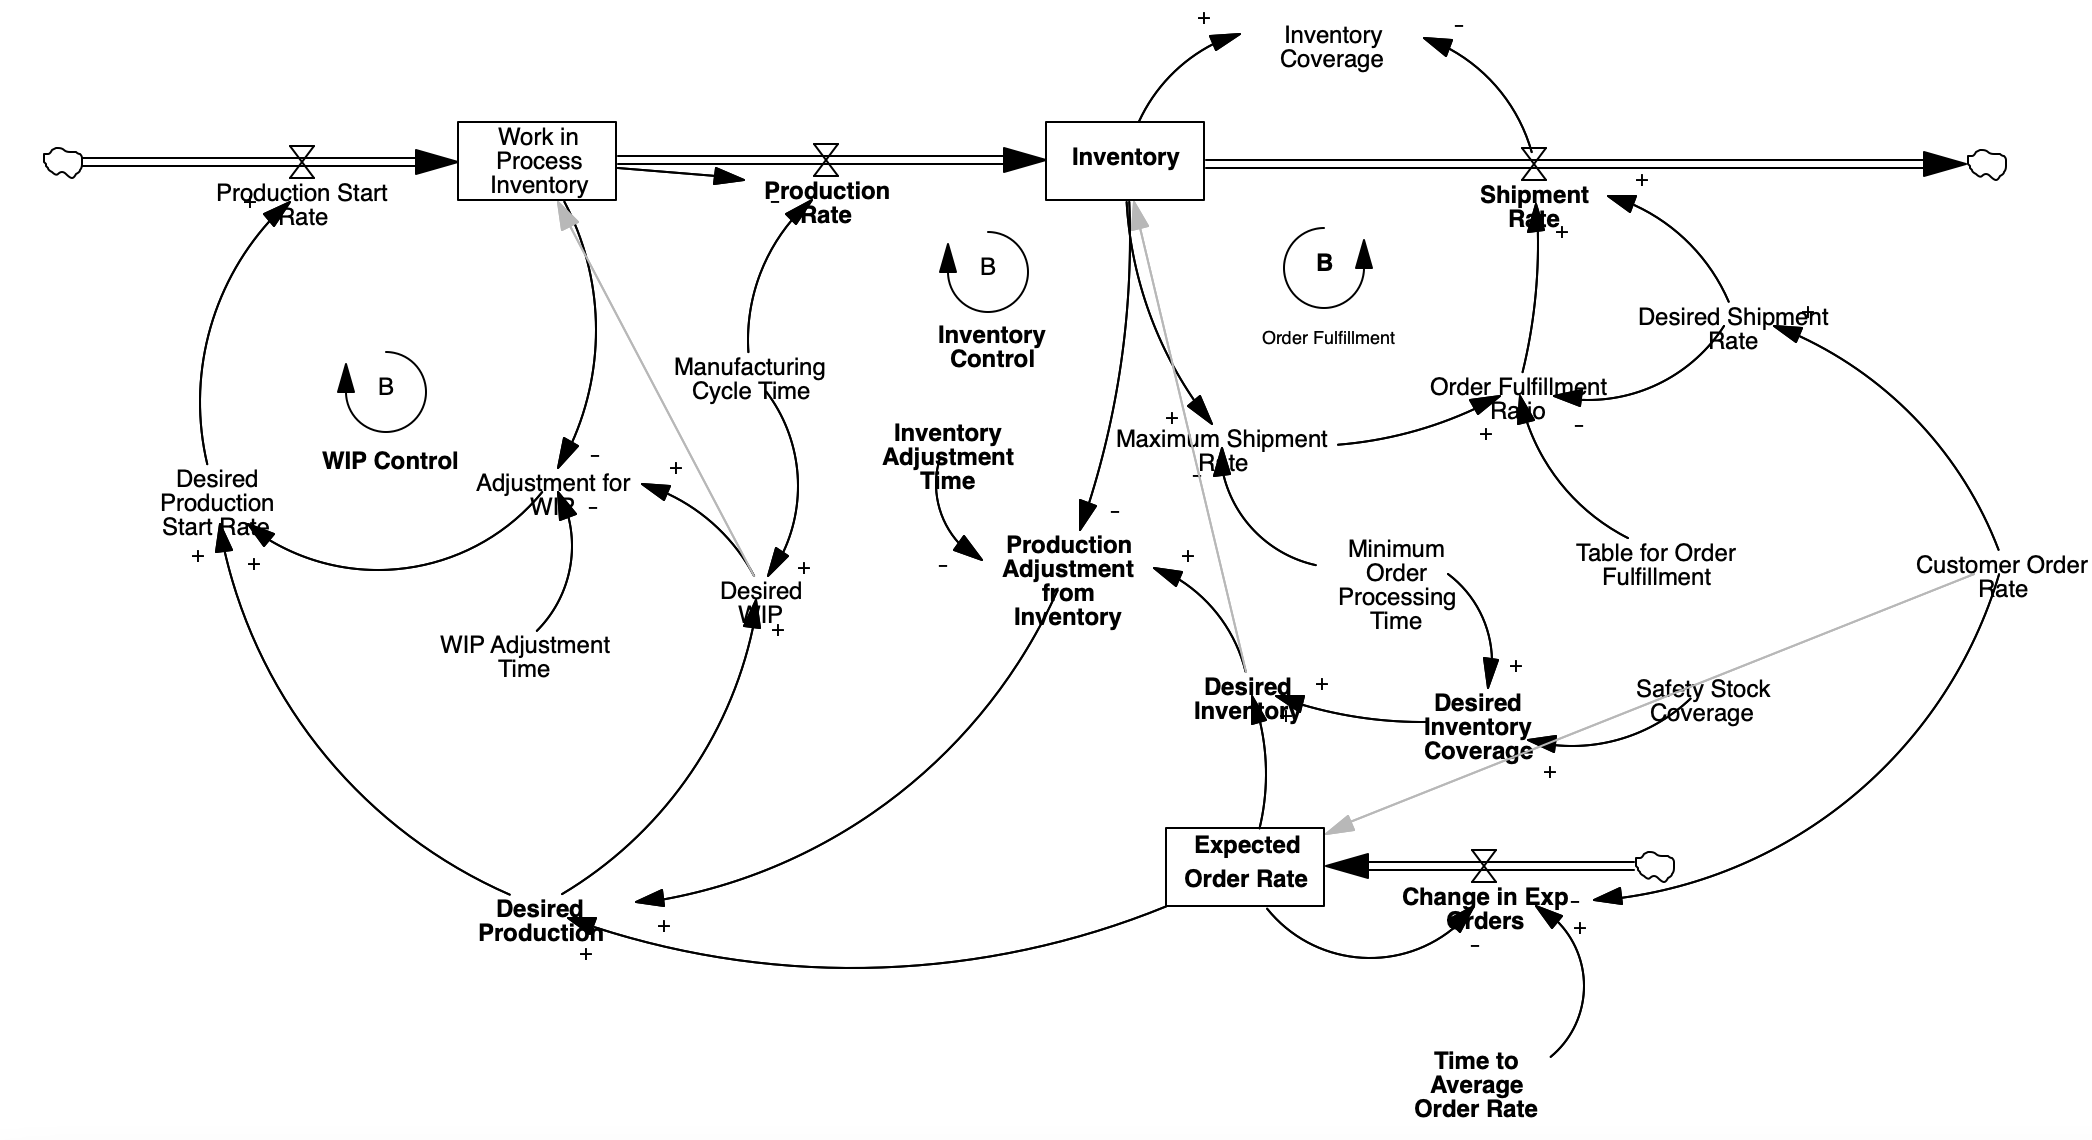

In [65]:
vf = VensimFile("vensim_models/ds_white_sterman.mdl")
vf.parse()
am = vf.get_abstract_model()
stan_builder = StanModelBuilder(am)
stan_builder.print_variable_info()

original name                        stan variable name                   is stock
----------------------------------------------------------------------------------
Adjustment for WIP                   adjustment_for_wip                   
Change in Exp Orders                 change_in_exp_orders                 
Customer Order Rate                  customer_order_rate                  
Desired Inventory                    desired_inventory                    
Desired Inventory Coverage           desired_inventory_coverage           
Desired Production                   desired_production                   
Desired Production Start Rate        desired_production_start_rate        
Desired Shipment Rate                desired_shipment_rate                
Desired WIP                          desired_wip                          
Expected Order Rate                  expected_order_rate                  V
Inventory                            inventory                            V
Invento

## U2. Classify

| variable name                   | `est_param` | `ass_param` | `obs_stock` |
| ------------------------------------ | ----------- | ----------- | ----------- |
| adjustment_for_wip                   |             |             |             |
| change_in_exp_orders                 |             |             |             |
| customer_order_rate                  |             | V           |             |
| desired_inventory                    |             |            |             |
| desired_inventory_coverage           |             |             |             |
| desired_production                   |             |             |             |
| desired_production_start_rate        |             |             |             |
| desired_shipment_rate                |             |             |             |
| desired_wip                          |             |             |             |
| expected_order_rate                  |             |             | V           |
| inventory                            |             |             | V           |
| inventory_adjustment_time            | V           |             |             |
| inventory_coverage                   |             | V           |             |
| manufacturing_cycle_time             |             | V           |             |
| maximum_shipment_rate                |             |             |             |
| minimum_order_processing_time        | V           |             |             |
| order_fulfillment_ratio              |             |            |             |
| production_adjustment_from_inventory |             |             |             |
| production_rate                      |             |             |             |
| production_start_rate                |             |             |             |
| safety_stock_coverage                |             |             |             |
| shipment_rate                        |             |             |             |
| table_for_order_fulfillment          |             | V (lookup)          |             |
| time_to_average_order_rate           |             | V           |             |
| wip_adjustment_time                  |             | V           |             |
| work_in_process_inventory            |             |             | V           |
| initial_time                         |             | V           |             |
| final_time                           |             | V           |             |
| time_step                            |             | V           |             |

The rest is `aux_var` which are derived from the defined.

In [66]:
ass_param_lst = ["customer_order_rate", "inventory_coverage", "manufacturing_cycle_time", "time_to_average_order_rate", "wip_adjustment_time"]
obs_stock_lst = ["work_in_process_inventory", "inventory"]

## P1. Relational_prior
From SD model (`.mdl`) to Stan ODE function block (`.stan`). No new information is added.

In [67]:
am = vf.get_abstract_model()
stan_function_builder = StanFunctionBuilder(am) 
ds_relational = stan_function_builder.build_function_block(ass_param_lst, obs_stock_lst)
print(ds_relational)
stan_file_path = os.path.join(os.getcwd(), "stan_file", "ds_relational.stan")
with open(stan_file_path, "w") as f:
    print(ds_relational, file=f)

functions {
    real lookupFunc_0(real x){
        # x (0, 2) = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0)
        # y (0, 1) = (0.0, 0.2, 0.4, 0.58, 0.73, 0.85, 0.93, 0.97, 0.99, 1.0, 1.0)
        real slope;
        real intercept;

        if(x <= 0.2)
            intercept = 0.0;
            slope = (0.2 - 0.0) / (0.2 - 0.0);
            return intercept + slope * (x - 0.0);
        else if(x <= 0.4)
            intercept = 0.2;
            slope = (0.4 - 0.2) / (0.4 - 0.2);
            return intercept + slope * (x - 0.2);
        else if(x <= 0.6)
            intercept = 0.4;
            slope = (0.58 - 0.4) / (0.6 - 0.4);
            return intercept + slope * (x - 0.4);
        else if(x <= 0.8)
            intercept = 0.58;
            slope = (0.73 - 0.58) / (0.8 - 0.6);
            return intercept + slope * (x - 0.6);
        else if(x <= 1.0)
            intercept = 0.73;
            slope = (0.85 - 0.73) / (1.0 - 0.8);
            return intercept + slope * (

## U3. Specify

#### Estimated parameter $\theta$ 

- declared in generated quantities block for `_draws2data.stan` and model block for `_data2draws.stan`.

| `ess_param`                     | (min, mode, max) | distribuiton type| 
| ------------------------------- | ---------------- | ------------ |
| `inventory_adjustment_time`     | (6,8,12)         | N(8, $1^2$)  |
| `minimum_order_processing_time` | (1,2,4)          | N(2, $.5^2$) |


Q1. Can `msr_err` (min, mode, max) be helpful info?
Q2. Shouldn't `msr_err` distribution determine `family`? Then, `Poisson`, `Neg_Binom`, `

#### Assumed parameter $X$ 

- declared in generated quantities block for `_draws2data.stan` and data block for `_data2draws.stan`.
- specified with its actual value or series or lookup function (aggregation)

| `ass_param`                  | value/series      |
| ---------------------------- | ----------------- |
| `customer_order_rate`        | N(10000, $100^2$) |
| `time_to_average_order_rate` | 8                 |
| `wip_adjustment_time`        | 8                 |
| `manufacturing_cycle_time`   | 8                 |
| `safety_stock_coverage`      | 2                 |
|`initial_time`, `final_time`, `time_step`  | 0, 10, .125|
|`table_for_order_fulfillment`| lookup function|



#### Latent stock $Z$

- declared in generated quantities block for `_draws2data.stan` and data block for `_data2draws.stan`.

#### Measurement error

- `msr_err` is specified with `family` and its parameter
| `msr_err`                 |??|lognormal, inverse_gamma|


#### Observed stock $Y$

- declared in generated quantities block for `_draws2data.stan` and data block for `_data2draws.stan`.
- $Y \sim$ `family`(Z, `msr_err` )

## P2. Variational_prior


- based on `est_param` specification (a = lower_bound, b=  most likely, c = upper_bound) in U3, its prior is automatically set to $\theta \sim N(\frac{a+4b+c}{6}, \frac{c-a}{6})$ using  [PERT dist](https://en.wikipedia.org/wiki/PERT_distribution)

| `ess_param`                     | Prior distribution | Prior parameter| 
| ------------------------------- | ---------------- | ------------ |
| `inventory_adjustment_time`     | Normal       | loc = 8, scale = $1^2$  |
| `minimum_order_processing_time` | Normal          |loc = 2, scale = $.5^2$ |
| `msr_err`                 |lognormal, inverse_gamma|

Q3. feedback on PERT?

Q4. how do we usually determine `msr_err`'s prior parameter?

In [58]:
initial_time = 0
final_time = 10
time_step = .125

N = int((final_time - initial_time)/time_step)
data_draws2data = {
    "N": N,
    "times": np.arange(1, N + 1),
    "customer_order_rate": np.random.normal(loc = 10000, scale = 100, size = N),
    "time_to_average_order_rate" : 8, 
    "wip_adjustment_time" :2,
    'manufacturing_cycle_time' : 8,
    'safety_stock_coverage' : 2
}

## P3. Draws2Data 

In [68]:
# first argument is `ass_param` and the second is `observed stock`. Design for `est_param` is under-development including how to express multi-levle prior
ds_draws2data = stan_builder.create_stan_program(ass_param_lst, obs_stock_lst)
#print(ds_draws2data)

In [63]:
sf_path_draws2data = os.path.join(os.getcwd(), "stan_file", "ds_draws2data.stan")
# with open(sf_path_draws2data, "w") as f:
#     print(ds_draws2data, file=f)

In [ ]:
sm_draws2data = CmdStanModel(stan_file = sf_path_draws2data)
fit_prior_pred = sm_draws2data.sample(data=data_draws2data, iter_sampling=30, chains=1, fixed_param=True, iter_warmup=0)

In [ ]:
fit_prior_pred.draws_xr()

<xarray.Dataset>
Dimensions:                  (draw: 30, chain: 1, y_init_tilde_dim_0: 2,
                              y_tilde_dim_0: 50, y_tilde_dim_1: 2,
                              sigma_tilde_dim_0: 2, z_init_tilde_dim_0: 2,
                              integrated_result_tilde_dim_0: 50,
                              integrated_result_tilde_dim_1: 2)
Coordinates:
  * chain                    (chain) int64 1
  * draw                     (draw) int64 0 1 2 3 4 5 6 ... 23 24 25 26 27 28 29
Dimensions without coordinates: y_init_tilde_dim_0, y_tilde_dim_0,
                                y_tilde_dim_1, sigma_tilde_dim_0,
                                z_init_tilde_dim_0,
                                integrated_result_tilde_dim_0,
                                integrated_result_tilde_dim_1
Data variables:
    y_init_tilde             (chain, draw, y_init_tilde_dim_0) float64 30.28 ...
    y_tilde                  (chain, draw, y_tilde_dim_0, y_tilde_dim_1) float64 ...
    sigma_tilde              (chain, draw, sigma_tilde_dim_0) float64 0.01 .....
    z_init_tilde             (chain, draw, z_init_tilde_dim_0) float64 30.0 ....
    alpha_tilde              (chain, draw) float64 0.55 0.55 0.55 ... 0.55 0.55
    beta_tilde               (chain, draw) float64 0.028 0.028 ... 0.028 0.028
    gamma_tilde              (chain, draw) float64 0.8 0.8 0.8 ... 0.8 0.8 0.8
    delta_tilde              (chain, draw) float64 0.024 0.024 ... 0.024 0.024
    integrated_result_tilde  (chain, draw, integrated_result_tilde_dim_0, integrated_result_tilde_dim_1) float64 ...
Attributes:
    stan_version:        2.30.0
    model:               pp_draws2data_model
    num_draws_sampling:  30

In [ ]:
fig, ax = plt.subplots()
#compare with real 
ax.plot(fit_prior_pred.loc[:, ['y_tilde']], label = "")
ax.plot(state_dt.loc[:, ['Predator']], label = "")
for i in range(len(obs_stock_lst)):
    ax.plot(pd.DataFrame(fit_prior_pred.y_tilde[:,:,i]).T.loc[:, :5])
ax.legend()

## P4. Data2Draws

In [24]:
sf_path_data2draws = os.path.join(os.getcwd(), "stan_file", "ds_data2draws.stan")
with open(sf_path_data2draws, "w") as f:
    print(ds_draws2data, file=f)

In [ ]:
idata = az.from_cmdstanpy(
    posterior=fit_posterior_draws, 
    posterior_predictive=["y_hat"], 
    log_likelihood= ["log_lik"],
    observed_data = {"y_hat": lynx_hare_df.loc[:, ("Hare", "Lynx")]}
#    dtypes={"y_rep": int} if Poisson family
)

In [ ]:
az.loo(idata)
az.plot_ppc(idata, alpha=0.03, figsize=(12, 6))

## P5. SBC